In [1]:
!nvidia-smi

Sun May 16 10:20:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install -q torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
# !conda install pytorch torchvision torchaudio cudatoolkit=11.1 -c pytorch -c nvidia
!pip install timm

     |████████████████████████████████| 287 kB 2.9 MB/s eta 0:00:01


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import timm
import random
import time
from collections import OrderedDict
from torch.cuda import amp
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms as T
from torchvision.io import read_image
from tqdm import tqdm
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


In [4]:
@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:k].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]


def set_debug_apis(state: bool = False):
    torch.autograd.profiler.profile(enabled=state)
    torch.autograd.profiler.emit_nvtx(enabled=state)
    torch.autograd.set_detect_anomaly(mode=state)


def seed_everything(seed):
    """
    Makes code deterministic using a given seed.
    Internally sets all seeds of torch, numpy and random.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print("Size (MB):", os.path.getsize("temp.p") / 1e6)
    os.remove("temp.p")

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
class RetinopathyDataset(Dataset):
    def __init__(self, image_dir, csv_file, transforms=None):
        self.data = pd.read_csv(csv_file)
        self.transforms = transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # img_name = os.path.join('../input/aptos2019-blindness-detection/train_images',
        #                         self.data.loc[idx, 'id_code'] + '.png')

        img_name = os.path.join(self.image_dir, self.data.loc[idx, 'id_code'] + '.png')

        tensor_image = read_image(img_name)
        label = torch.tensor(self.data.loc[idx, 'diagnosis'], dtype=torch.long)

        if self.transforms is not None:
            tensor_image = self.transforms(tensor_image)

        return (tensor_image, label)

In [6]:
print(torch.cuda.is_available())

True


In [7]:
def train_step(model: nn.Module, train_loader, criterion,
               device: str, optimizer,
               scheduler=None, num_batches: int = None,
               log_interval: int = 100,
               scaler=None,):
    """
    Performs one step of training. Calculates loss, forward pass, computes gradient and returns metrics.
    Args:
        model : A pytorch CNN Model.
        train_loader : Train loader.
        criterion : Loss function to be optimized.
        device : "cuda" or "cpu"
        optimizer : Torch optimizer to train.
        scheduler : Learning rate scheduler.
        num_batches : (optional) Integer To limit training to certain number of batches.
        log_interval : (optional) Defualt 100. Integer to Log after specified batch ids in every batch.
        scaler: (optional)  Pass torch.cuda.amp.GradScaler() for fp16 precision Training.
    """

    model = model.to(device)
    start_train_step = time.time()
    metrics = OrderedDict()
    model.train()
    last_idx = len(train_loader) - 1
    batch_time_m = AverageMeter()
    # data_time_m = AverageMeter()
    losses_m = AverageMeter()
    top1_m = AverageMeter()
    top5_m = AverageMeter()
    cnt = 0
    batch_start = time.time()
    # num_updates = epoch * len(loader)

    for batch_idx, (inputs, target) in enumerate(train_loader):
        last_batch = batch_idx == last_idx
        # data_time_m.update(time.time() - batch_start)
        inputs = inputs.to(device)
        target = target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        if scaler is not None:
            with amp.autocast():
                output = model(inputs)
                loss = criterion(output, target)
                # Scale the loss using Grad Scaler
            scaler.scale(loss).backward()
            # Step using scaler.step()
            scaler.step(optimizer)
            # Update for next iteration
            scaler.update()

        else:
            output = model(inputs)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        cnt += 1
        acc1, acc5 = accuracy(output, target, topk=(1, 5))

        top1_m.update(acc1.item(), output.size(0))
        top5_m.update(acc5.item(), output.size(0))
        losses_m.update(loss.item(), inputs.size(0))

        batch_time_m.update(time.time() - batch_start)
        batch_start = time.time()
        if last_batch or batch_idx % log_interval == 0:  # If we reach the log intervel
            print(
                "Batch Train Time: {batch_time.val:.3f} ({batch_time.avg:.3f})  "
                "Loss: {loss.val:>7.4f} ({loss.avg:>6.4f})  "
                "Top 1 Accuracy: {top1.val:>7.4f} ({top1.avg:>7.4f})  "
                "Top 5 Accuracy: {top5.val:>7.4f} ({top5.avg:>7.4f})".format(
                    batch_time=batch_time_m, loss=losses_m, top1=top1_m, top5=top5_m))

        if num_batches is not None:
            if cnt >= num_batches:
                end_train_step = time.time()
                metrics["loss"] = losses_m.avg
                metrics["top1"] = top1_m.avg
                metrics["top5"] = top5_m.avg
                print(f"Done till {num_batches} train batches")
                print(f"Time taken for train step = {end_train_step - start_train_step} sec")
                return metrics

    metrics["loss"] = losses_m.avg
    metrics["top1"] = top1_m.avg
    metrics["top5"] = top5_m.avg
    end_train_step = time.time()
    print(f"Time taken for train step = {end_train_step - start_train_step} sec")
    return metrics

In [8]:
@torch.no_grad()
def val_step(model: nn.Module, val_loader, criterion,
             device: str, num_batches=None,
             log_interval: int = 100):

    """
    Performs one step of validation. Calculates loss, forward pass and returns metrics.
    Args:
        model : A pytorch CNN Model.
        val_loader : Validation loader.
        criterion : Loss function to be optimized.
        device : "cuda" or "cpu"
        num_batches : (optional) Integer To limit validation to certain number of batches.
        log_interval : (optional) Defualt 100. Integer to Log after specified batch ids in every batch.
    """

    model = model.to(device)
    start_val_step = time.time()
    last_idx = len(val_loader) - 1
    batch_time_m = AverageMeter()
    # data_time_m = AverageMeter()
    losses_m = AverageMeter()
    top1_m = AverageMeter()
    top5_m = AverageMeter()
    cnt = 0
    model.eval()
    batch_start = time.time()
    metrics = OrderedDict()

    for batch_idx, (inputs, target) in enumerate(val_loader):
        last_batch = batch_idx == last_idx
        inputs = inputs.to(device)
        target = target.to(device)

        output = model(inputs)
        loss = criterion(output, target)
        cnt += 1
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        reduced_loss = loss.data

        losses_m.update(reduced_loss.item(), inputs.size(0))
        top1_m.update(acc1.item(), output.size(0))
        top5_m.update(acc5.item(), output.size(0))
        batch_time_m.update(time.time() - batch_start)

        batch_start = time.time()

        if (last_batch or batch_idx % log_interval == 0):  # If we reach the log intervel
            print(
                "Batch Inference Time: {batch_time.val:.3f} ({batch_time.avg:.3f})  "
                "Loss: {loss.val:>7.4f} ({loss.avg:>6.4f})  "
                "Top 1 Accuracy: {top1.val:>7.4f} ({top1.avg:>7.4f})  "
                "Top 5 Accuracy: {top5.val:>7.4f} ({top5.avg:>7.4f})".format(
                    batch_time=batch_time_m, loss=losses_m, top1=top1_m, top5=top5_m))

        if num_batches is not None:
            if cnt >= num_batches:
                end_val_step = time.time()
                metrics["loss"] = losses_m.avg
                metrics["top1"] = top1_m.avg
                metrics["top5"] = top5_m.avg
                print(f"Done till {num_batches} validation batches")
                print(f"Time taken for validation step = {end_val_step - start_val_step} sec")
                return metrics

    metrics["loss"] = losses_m.avg
    metrics["top1"] = top1_m.avg
    metrics["top5"] = top5_m.avg
    print("Finished the validation epoch")

    end_val_step = time.time()
    print(f"Time taken for validation step = {end_val_step - start_val_step} sec")
    return metrics


In [9]:
DATA_DIR = "../input/aptos2019-blindness-detection/"
TRAIN_DIR = "../input/aptos2019-blindness-detection/train_images"
CSV_PATH = "../input/aptos2019-blindness-detection/train.csv"
MODEL_PATH = "."


TRAIN_SPLIT = 0.8
# Automaticllay
# VAL_SPLIT = 0.2

LEARNING_RATE = 1e-4
TRAIN_BATCH_SIZE = 32
# TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 16

NUM_WORKERS = 2
EPOCHS = 15

IMG_WIDTH = 224
IMG_HEIGHT = 224

MODEL_NAME = "vit_base_patch16_224"
# vit_deit_base_patch16_384

# MODEL_NAME = "resnet_50"


MODEL_SAVE = MODEL_PATH + MODEL_NAME
USE_AMP = True



In [10]:
seed_everything(42)
set_debug_apis(False)

train_trasforms = T.Compose([
    T.ConvertImageDtype(torch.float32),
    T.Resize((IMG_WIDTH, IMG_HEIGHT)),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=.5, hue=.3),
    
])

full_dataset = RetinopathyDataset(TRAIN_DIR, CSV_PATH, transforms=train_trasforms)

train_size = int(TRAIN_SPLIT * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(full_dataset, batch_size=TRAIN_BATCH_SIZE,
                          shuffle=False, num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

# for batch_idx, (inputs, target) in enumerate(train_loader):
#     print(batch_idx)
#     # print(inputs)
#     print(target)
#     break

In [11]:
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

if USE_AMP:
    from torch.cuda import amp
    scaler = amp.GradScaler()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


In [12]:
train_loss = []
train_top1_acc = []
val_loss = []
val_top1_acc = []

for epoch in tqdm(range(EPOCHS)):
    train_metrics = train_step(model, train_loader, criterion, device, optimizer, scaler=scaler)
    train_loss.append(train_metrics["loss"])
    print(f"Training loss = {train_metrics['loss']}")
    train_top1_acc.append(train_metrics["top1"])

    val_metrics = val_step(model, val_loader, criterion, device)
    val_loss.append(val_metrics["loss"])
    print(f"Validation loss = {val_metrics['loss']}")
    val_top1_acc.append(val_metrics["top1"])
    
    torch.save(model.state_dict(), f"{MODEL_NAME}_{epoch}" + ".pt")

  0%|          | 0/15 [00:00<?, ?it/s]

Batch Train Time: 11.154 (11.154)  Loss:  1.6272 (1.6272)  Top 1 Accuracy: 28.1250 (28.1250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.752 (3.758)  Loss:  0.7820 (0.8941)  Top 1 Accuracy: 71.8750 (68.4406)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 1.933 (3.743)  Loss:  0.8724 (   nan)  Top 1 Accuracy: 62.5000 (68.8871)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 426.77027678489685 sec
Training loss = nan
Batch Inference Time: 7.895 (7.895)  Loss:  0.9211 (0.9211)  Top 1 Accuracy: 68.7500 (68.7500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.530 (3.540)  Loss:  0.6694 (0.7717)  Top 1 Accuracy: 65.6250 (72.3011)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 77.92059350013733 sec
Validation loss = 0.7716738933866675


  7%|▋         | 1/15 [08:31<1:59:16, 511.21s/it]

Batch Train Time: 8.187 (8.187)  Loss:  0.6048 (0.6048)  Top 1 Accuracy: 68.7500 (68.7500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.661 (3.537)  Loss:  0.6479 (0.7602)  Top 1 Accuracy: 75.0000 (72.0297)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.617 (3.515)  Loss:  0.6782 (   nan)  Top 1 Accuracy: 65.6250 (72.3958)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 400.767915725708 sec
Training loss = nan
Batch Inference Time: 7.332 (7.332)  Loss:  0.7453 (0.7453)  Top 1 Accuracy: 75.0000 (75.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.214 (3.477)  Loss:  0.6861 (0.7168)  Top 1 Accuracy: 62.5000 (73.5795)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 76.52992248535156 sec
Validation loss = 0.7168217436833815


 13%|█▎        | 2/15 [16:29<1:46:33, 491.84s/it]

Batch Train Time: 7.833 (7.833)  Loss:  0.5827 (0.5827)  Top 1 Accuracy: 71.8750 (71.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 1.140 (3.512)  Loss:  0.6520 (0.7120)  Top 1 Accuracy: 75.0000 (74.1646)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 1.057 (3.486)  Loss:  0.7735 (0.7073)  Top 1 Accuracy: 65.6250 (74.4243)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 397.4067029953003 sec
Training loss = 0.7073264874910054
Batch Inference Time: 8.054 (8.054)  Loss:  0.6910 (0.6910)  Top 1 Accuracy: 65.6250 (65.6250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.296 (3.496)  Loss:  0.6099 (0.6442)  Top 1 Accuracy: 71.8750 (77.1307)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 76.9578857421875 sec
Validation loss = 0.6442317298867486


 20%|██        | 3/15 [24:24<1:36:51, 484.32s/it]

Batch Train Time: 8.153 (8.153)  Loss:  0.5757 (0.5757)  Top 1 Accuracy: 81.2500 (81.2500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.688 (3.531)  Loss:  0.6518 (   nan)  Top 1 Accuracy: 78.1250 (75.1547)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.494 (3.510)  Loss:  0.6328 (   nan)  Top 1 Accuracy: 75.0000 (75.5482)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 400.1879758834839 sec
Training loss = nan
Batch Inference Time: 8.321 (8.321)  Loss:  0.7883 (0.7883)  Top 1 Accuracy: 75.0000 (75.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.168 (3.530)  Loss:  0.5467 (0.6661)  Top 1 Accuracy: 78.1250 (76.2784)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 77.72526717185974 sec
Validation loss = 0.6660537787459113


 27%|██▋       | 4/15 [32:23<1:28:24, 482.27s/it]

Batch Train Time: 7.972 (7.972)  Loss:  0.5366 (0.5366)  Top 1 Accuracy: 81.2500 (81.2500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.633 (3.551)  Loss:  0.5740 (   nan)  Top 1 Accuracy: 78.1250 (77.5990)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.357 (3.517)  Loss:  0.6579 (   nan)  Top 1 Accuracy: 68.7500 (77.5493)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 401.00855112075806 sec
Training loss = nan
Batch Inference Time: 7.538 (7.538)  Loss:  0.6505 (0.6505)  Top 1 Accuracy: 75.0000 (75.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.826 (3.509)  Loss:  0.5280 (0.6127)  Top 1 Accuracy: 84.3750 (78.5511)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 77.26271724700928 sec
Validation loss = 0.6126636415719986


 33%|███▎      | 5/15 [40:23<1:20:12, 481.22s/it]

Batch Train Time: 8.065 (8.065)  Loss:  0.5357 (0.5357)  Top 1 Accuracy: 75.0000 (75.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.650 (3.547)  Loss:  0.6153 (   nan)  Top 1 Accuracy: 78.1250 (78.6510)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.676 (3.519)  Loss:  0.7547 (   nan)  Top 1 Accuracy: 68.7500 (78.7555)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 401.1580502986908 sec
Training loss = nan
Batch Inference Time: 7.371 (7.371)  Loss:  0.6956 (0.6956)  Top 1 Accuracy: 75.0000 (75.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.026 (3.469)  Loss:  0.4689 (0.5908)  Top 1 Accuracy: 81.2500 (77.6989)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 76.36531710624695 sec
Validation loss = 0.5907646878199144


 40%|████      | 6/15 [48:21<1:12:02, 480.31s/it]

Batch Train Time: 8.468 (8.468)  Loss:  0.4461 (0.4461)  Top 1 Accuracy: 81.2500 (81.2500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.687 (3.510)  Loss:  0.5194 (0.5638)  Top 1 Accuracy: 81.2500 (79.8886)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.563 (3.489)  Loss:  0.6232 (   nan)  Top 1 Accuracy: 68.7500 (79.5230)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 397.7305703163147 sec
Training loss = nan
Batch Inference Time: 7.266 (7.266)  Loss:  0.5845 (0.5845)  Top 1 Accuracy: 75.0000 (75.0000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.124 (3.457)  Loss:  0.5486 (0.5693)  Top 1 Accuracy: 78.1250 (79.8295)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 76.09930086135864 sec
Validation loss = 0.5692575167525898


 47%|████▋     | 7/15 [56:16<1:03:48, 478.51s/it]

Batch Train Time: 7.863 (7.863)  Loss:  0.5041 (0.5041)  Top 1 Accuracy: 78.1250 (78.1250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.671 (3.508)  Loss:  0.5504 (   nan)  Top 1 Accuracy: 78.1250 (81.3738)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.767 (3.492)  Loss:  0.4714 (   nan)  Top 1 Accuracy: 81.2500 (81.2774)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 398.1405186653137 sec
Training loss = nan
Batch Inference Time: 7.636 (7.636)  Loss:  0.3458 (0.3458)  Top 1 Accuracy: 93.7500 (93.7500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.330 (3.462)  Loss:  0.4836 (0.5362)  Top 1 Accuracy: 81.2500 (82.5284)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 76.19548296928406 sec
Validation loss = 0.5362314615737308


 53%|█████▎    | 8/15 [1:04:11<55:42, 477.48s/it]

Batch Train Time: 7.923 (7.923)  Loss:  0.4770 (0.4770)  Top 1 Accuracy: 84.3750 (84.3750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.649 (3.513)  Loss:  0.5792 (   nan)  Top 1 Accuracy: 81.2500 (82.4567)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.383 (3.496)  Loss:  0.4940 (   nan)  Top 1 Accuracy: 81.2500 (82.4836)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 398.6043977737427 sec
Training loss = nan
Batch Inference Time: 7.928 (7.928)  Loss:  0.5586 (0.5586)  Top 1 Accuracy: 71.8750 (71.8750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.479 (3.520)  Loss:  0.4262 (0.5009)  Top 1 Accuracy: 87.5000 (81.6761)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 77.48028111457825 sec
Validation loss = 0.5008750984614546


 60%|██████    | 9/15 [1:12:09<47:44, 477.36s/it]

Batch Train Time: 8.112 (8.112)  Loss:  0.4885 (0.4885)  Top 1 Accuracy: 87.5000 (87.5000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.642 (3.561)  Loss:  0.4130 (0.4597)  Top 1 Accuracy: 84.3750 (83.9728)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.749 (3.539)  Loss:  0.3144 (   nan)  Top 1 Accuracy: 90.6250 (83.9638)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 403.4780294895172 sec
Training loss = nan
Batch Inference Time: 7.834 (7.834)  Loss:  0.4796 (0.4796)  Top 1 Accuracy: 78.1250 (78.1250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.096 (3.549)  Loss:  0.3997 (0.4490)  Top 1 Accuracy: 84.3750 (84.6591)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 78.1094102859497 sec
Validation loss = 0.4490285481918942


 67%|██████▋   | 10/15 [1:20:11<39:54, 478.99s/it]

Batch Train Time: 8.116 (8.116)  Loss:  0.4206 (0.4206)  Top 1 Accuracy: 81.2500 (81.2500)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.660 (3.632)  Loss:  0.3625 (0.4046)  Top 1 Accuracy: 90.6250 (85.9530)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.956 (3.600)  Loss:  0.3973 (   nan)  Top 1 Accuracy: 87.5000 (85.8553)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 410.4616858959198 sec
Training loss = nan
Batch Inference Time: 7.507 (7.507)  Loss:  0.3759 (0.3759)  Top 1 Accuracy: 78.1250 (78.1250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.104 (3.537)  Loss:  0.4196 (0.4217)  Top 1 Accuracy: 84.3750 (85.6534)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 77.85476493835449 sec
Validation loss = 0.42172018777240405


 73%|███████▎  | 11/15 [1:28:21<32:08, 482.17s/it]

Batch Train Time: 7.975 (7.975)  Loss:  0.4113 (0.4113)  Top 1 Accuracy: 78.1250 (78.1250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.667 (3.531)  Loss:  0.5428 (   nan)  Top 1 Accuracy: 87.5000 (85.6126)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.529 (3.501)  Loss:  0.3435 (   nan)  Top 1 Accuracy: 87.5000 (85.4715)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 399.1530530452728 sec
Training loss = nan
Batch Inference Time: 7.584 (7.584)  Loss:  0.4454 (0.4454)  Top 1 Accuracy: 84.3750 (84.3750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.304 (3.461)  Loss:  0.4546 (0.4438)  Top 1 Accuracy: 90.6250 (85.6534)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 76.18726682662964 sec
Validation loss = 0.4438139044425704


 80%|████████  | 12/15 [1:36:17<24:01, 480.38s/it]

Batch Train Time: 8.651 (8.651)  Loss:  0.3469 (0.3469)  Top 1 Accuracy: 90.6250 (90.6250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.649 (3.510)  Loss:  0.3537 (0.3748)  Top 1 Accuracy: 87.5000 (87.7785)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.601 (3.487)  Loss:  0.3599 (0.3797)  Top 1 Accuracy: 87.5000 (87.5548)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 397.5706465244293 sec
Training loss = 0.37973124579640855
Batch Inference Time: 7.663 (7.663)  Loss:  0.4084 (0.4084)  Top 1 Accuracy: 84.3750 (84.3750)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.585 (3.464)  Loss:  0.3571 (0.3680)  Top 1 Accuracy: 87.5000 (88.0682)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 76.24523544311523 sec
Validation loss = 0.36798613383011386


 87%|████████▋ | 13/15 [1:44:12<15:57, 478.69s/it]

Batch Train Time: 8.166 (8.166)  Loss:  0.3145 (0.3145)  Top 1 Accuracy: 90.6250 (90.6250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.687 (3.511)  Loss:  0.3027 (0.3671)  Top 1 Accuracy: 93.7500 (87.5928)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.426 (3.487)  Loss:  0.3454 (   nan)  Top 1 Accuracy: 90.6250 (87.5000)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 397.56853699684143 sec
Training loss = nan
Batch Inference Time: 7.654 (7.654)  Loss:  0.3772 (0.3772)  Top 1 Accuracy: 87.5000 (87.5000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.190 (3.484)  Loss:  0.3653 (0.3623)  Top 1 Accuracy: 87.5000 (87.3580)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 76.68980669975281 sec
Validation loss = 0.36229749904437497


 93%|█████████▎| 14/15 [1:52:07<07:57, 477.67s/it]

Batch Train Time: 8.139 (8.139)  Loss:  0.3181 (0.3181)  Top 1 Accuracy: 87.5000 (87.5000)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 0.679 (3.551)  Loss:  0.4113 (0.3584)  Top 1 Accuracy: 84.3750 (87.5928)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Train Time: 3.410 (3.522)  Loss:  0.3048 (   nan)  Top 1 Accuracy: 90.6250 (87.5548)  Top 5 Accuracy: 100.0000 (100.0000)
Time taken for train step = 401.58530044555664 sec
Training loss = nan
Batch Inference Time: 7.713 (7.713)  Loss:  0.4317 (0.4317)  Top 1 Accuracy: 78.1250 (78.1250)  Top 5 Accuracy: 100.0000 (100.0000)
Batch Inference Time: 3.563 (3.498)  Loss:  0.4440 (0.4182)  Top 1 Accuracy: 84.3750 (87.0739)  Top 5 Accuracy: 100.0000 (100.0000)
Finished the validation epoch
Time taken for validation step = 76.99247550964355 sec
Validation loss = 0.41819773749871686


100%|██████████| 15/15 [2:00:07<00:00, 480.47s/it]


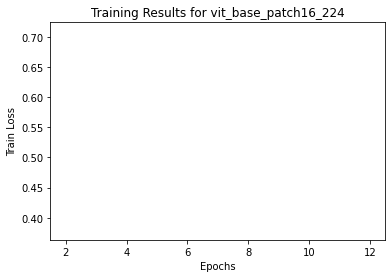

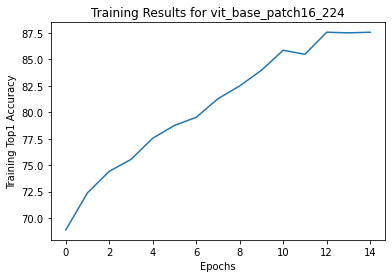

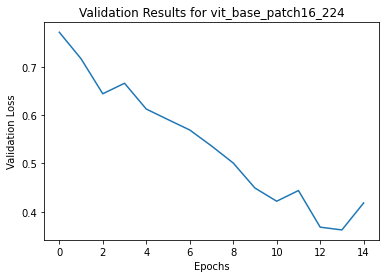

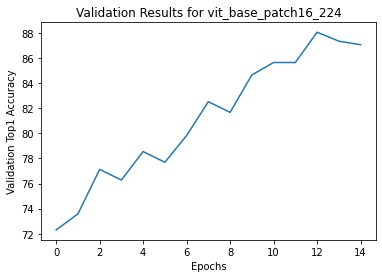

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.title(f"Training Results for {MODEL_NAME}")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()


plt.plot(train_top1_acc)
plt.title(f"Training Results for {MODEL_NAME}")
plt.xlabel("Epochs")
plt.ylabel("Training Top1 Accuracy")
plt.show()


plt.plot(val_loss)
plt.title(f"Validation Results for {MODEL_NAME}")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()


plt.plot(val_top1_acc)
plt.title(f"Validation Results for {MODEL_NAME}")
plt.xlabel("Epochs")
plt.ylabel("Validation Top1 Accuracy")
plt.show()

In [14]:
# timm.list_models(pretrained=True)